In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Load the data

In [2]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [3]:
y.shape, tx.shape

((10000,), (10000, 2))

# 1 Computing the Cost Function

Fill in the `compute_loss` function below:
<a id='compute_loss'></a>


In [9]:
def loss_mse(e):
    """Compute the Mean Square Error for the vector e"""
    return 1 / 2 * np.mean(e ** 2)

def loss_mae(e):
    """Compute the Mean Absolute Error for the vector e"""
    return np.mean(np.abs(e))

def compute_loss(y, tx, w):
    """Calculate the loss.

    You can calculate the loss using mse or mae.
    """
    e = y - tx.dot(w)
    return loss_mse(e)

# 2 Grid Search

Fill in the function `grid_search()` below:

In [10]:
def grid_search(y, tx, w0, w1):
    """Algorithm for grid search."""
    losses = np.zeros((len(w0), len(w1)))
    for i, p0 in enumerate(w0):
        for j, p1 in enumerate(w1):
            losses[i, j] = compute_loss(y, tx, np.array([p0, p1]))
    return losses

Let us play with the grid search demo now!

Grid Search: loss*=18.793541019523236, w0*=71.42857142857142, w1*=15.306122448979579, execution time=0.165 seconds


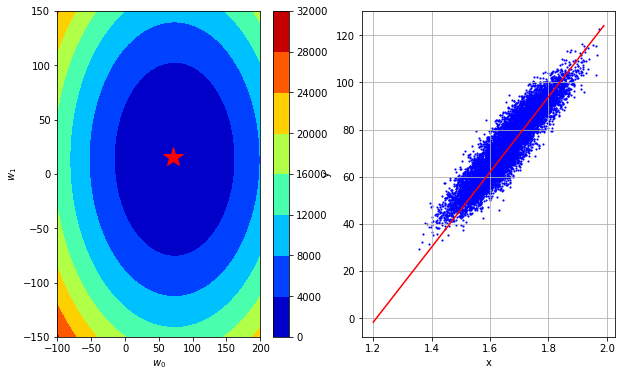

In [15]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=50)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print("Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
      l=loss_star, w0=w0_star, w1=w1_star, t=execution_time))

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0,6.0)
fig.savefig("grid_plot")  # Optional saving

# 3 Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [19]:
def compute_gradient(y, tx, w):
    """Compute the gradient."""
    err = y - tx.dot(w)
    grad = -tx.T.dot(err) / len(err)
    return grad, err
compute_gradient(y, tx, np.array([50, 10]))

(array([-23.293922  ,  -3.47971243]),
 array([40.37906275, 17.41358774, 26.45991385, ..., 14.82467389,
        17.45777059, 13.09377573]))

Please fill in the functions `gradient_descent` below:

In [59]:
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """Gradient descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        grad, err = compute_gradient(y, tx, w)
        loss = loss_mse(err)
        w = w - gamma * grad
        # store w and loss
        ws.append(w)
        losses.append(loss)
        print("Gradient Descent({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

In [60]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gradient_losses, gradient_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time={t:.3f} seconds".format(t=exection_time))

Gradient Descent(0/49): loss=2792.2367127591674, w0=51.30574540147352, w1=9.435798704492393
Gradient Descent(1/49): loss=265.302462108962, w0=66.69746902191565, w1=12.266538315840034
Gradient Descent(2/49): loss=37.87837955044161, w0=71.31498610804833, w1=13.115760199244338
Gradient Descent(3/49): loss=17.410212120174496, w0=72.70024123388814, w1=13.370526764265632
Gradient Descent(4/49): loss=15.568077051450455, w0=73.11581777164008, w1=13.446956733772023
Gradient Descent(5/49): loss=15.402284895265295, w0=73.24049073296567, w1=13.469885724623941
Gradient Descent(6/49): loss=15.38736360120863, w0=73.27789262136332, w1=13.476764421879517
Gradient Descent(7/49): loss=15.38602068474353, w0=73.28911318788263, w1=13.478828031056189
Gradient Descent(8/49): loss=15.385899822261674, w0=73.29247935783842, w1=13.47944711380919
Gradient Descent(9/49): loss=15.385888944638305, w0=73.29348920882516, w1=13.47963283863509
Gradient Descent(10/49): loss=15.3858879656522, w0=73.29379216412119, w1=13.47

In [61]:
# Time Visualization
from ipywidgets import IntSlider, interact

def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gradient_losses, gradient_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gradient_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 4 Stochastic gradient descent

In [65]:
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient from just few examples n and their corresponding y_n labels."""
    return compute_gradient(y, tx, w)

def stochastic_gradient_descent(
        y, tx, initial_w, batch_size, max_iters, gamma):
    """Stochastic gradient descent algorithm."""
    ws = [initial_w]
    losses = []
    w = initial_w
    current_iter = 0
    for n_iter in range(max_iters):
        for minibatch_y, minibatch_tx in batch_iter(y, tx, batch_size, num_batches = 1):
            gradient, err= compute_stoch_gradient(minibatch_y, minibatch_tx, w)
            w = w - gamma * gradient
            loss = loss_mse(err)
            ws.append(w)
            losses.append(loss)
        print("SGD({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
    return losses, ws

In [66]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD(0/49): loss=1689.5336315280058, w0=40.690821555941156, w1=-13.937948450325974
SGD(1/49): loss=73.54538398223954, w0=32.20115275777272, w1=0.8948602724302361
SGD(2/49): loss=393.77387663572785, w0=51.84544961724349, w1=-13.480629583435343
SGD(3/49): loss=936.2417373330836, w0=82.13599108791419, w1=9.749876291224952
SGD(4/49): loss=0.2265475971711815, w0=81.66480466490546, w1=8.88712323062124
SGD(5/49): loss=68.62353204682793, w0=73.46413021667308, w1=11.526998190666683
SGD(6/49): loss=13.549446406616982, w0=77.10809200001887, w1=13.525363745024821
SGD(7/49): loss=24.54354807778854, w0=72.20373912565994, w1=20.312225873272553
SGD(8/49): loss=64.21651697374153, w0=80.13672006817245, w1=19.253718045869956
SGD(9/49): loss=56.777331129531454, w0=72.67737797205292, w1=14.710479599999154
SGD(10/49): loss=19.05191696100398, w0=68.35639676151938, w1=13.344053274322501
SGD(11/49): loss=54.31865209592889, w0=75.6524422009345, w1=9.634658615365836
SGD(12/49): loss=38.06860015565254, w0=81.76040

In [67]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses, sgd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gradient_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 5 Effect of Outliers and MAE Cost Function, and Subgradient Descent

### Exercise 5

Load and plot data containing outliers

In [69]:
height, weight, gender = load_data(sub_sample=False, add_outlier=True)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gradient_losses, gradient_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time={t:.3f} seconds".format(t=exection_time))

# Time Visualization
from ipywidgets import IntSlider, interact

def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gradient_losses, gradient_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gradient_ws)))

Gradient Descent(0/49): loss=2793.0633249190396, w0=51.311949971831574, w1=9.375829281932592
Gradient Descent(1/49): loss=266.58539632874687, w0=66.70553496338115, w1=12.188578066512369
Gradient Descent(2/49): loss=39.20238275561819, w0=71.32361046084603, w1=13.032402701886323
Gradient Descent(3/49): loss=18.737911534036595, w0=72.70903311008549, w1=13.285550092498509
Gradient Descent(4/49): loss=16.896109124094252, w0=73.12465990485732, w1=13.361494309682165
Gradient Descent(5/49): loss=16.73034690719944, w0=73.24934794328887, w1=13.384277574837261
Gradient Descent(6/49): loss=16.715428307678906, w0=73.28675435481834, w1=13.39111255438379
Gradient Descent(7/49): loss=16.714085633722057, w0=73.29797627827718, w1=13.393163048247748
Gradient Descent(8/49): loss=16.713964793065944, w0=73.30134285531484, w1=13.393778196406936
Gradient Descent(9/49): loss=16.713953917406897, w0=73.30235282842614, w1=13.393962740854693
Gradient Descent(10/49): loss=16.71395293859758, w0=73.30265582035952, w1

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

### Exercise 6

Modify the function `compute_loss(y, tx, w)` for the Mean Absolute Error cost function [here](#compute_loss)